# **Project 3. Prediction of hotel rating on Booking.com**

![booking logo](https://i1.wp.com/blog.keycafe.com/wp-content/uploads/2019/05/screen-shot-2017-10-24-at-9-54-22-am.png?w=1091&ssl=1)

## **Defining the problem**

**One of the problems in the company is dishonest hotels that cheat with their rating. One way to find such hotels is to build a model that predicts the rating of the hotel. If the predictions of the model are very different from the actual result, then the hotel may be playing unfairly and should be checked. Our task is to create such model.**

## **Features in the initial dataset**

* hotel_address - hotel address;
* review_date — date when the reviewer posted the corresponding review;
* average_score - the hotel's average score, calculated based on the last comment for the last year;
* hotel_name — hotel name;
* reviewer_nationality — reviewer's country;
* negative_review - negative review that the reviewer gave to the hotel;
* review_total_negative_word_counts - total number of words in the negative review;
* positive_review — positive review given by the reviewer to the hotel;
* review_total_positive_word_counts - total number of words in a positive review.
* reviewer_score - the rating given by the reviewer to the hotel based on their experience;
* total_number_of_reviews_reviewer_has_given - the number of reviews that reviewers have given in the past;
* total_number_of_reviews - total number of valid hotel reviews;
* tags — tags that the reviewer gave to the hotel;
* days_since_review - the number of days between the review date and the cleanup date;
* additional_number_of_scoring - There are also some guests who simply rated the service but didn't leave a review. This number indicates how many valid grades there are without validation.
* lat is the geographical latitude of the hotel;
* lng is the geographic longitude of the hotel.



In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/world-cities-database/LICENSE.txt
/kaggle/input/world-cities-database/worldcitiespop.csv
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv
/kaggle/input/countries-of-the-world/countries of the world.csv


In [82]:
!pip install pycountry-convert

In [83]:
# Graphs and plots
import matplotlib.pyplot as plt
import seaborn as sns

# Geography
import pycountry

# Math
from math import sin, cos, sqrt, atan2, radians

# Categories
import category_encoders as ce

# Countries management
import pycountry_convert as pc

# Review analyser
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Model learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

## **0. Data loading**

In [84]:
INPUT_DIR = '../input/sf-booking/'

In [85]:
train_data = pd.read_csv(INPUT_DIR + 'hotels_train.csv')
print(train_data.shape)
train_data.head()

(386803, 17)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [86]:
test_data = pd.read_csv(INPUT_DIR + 'hotels_test.csv')
print(test_data.shape)
test_data.head()

(128935, 16)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [87]:
submission = pd.read_csv(INPUT_DIR + 'submission.csv')
print(submission.shape)
submission.head()

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [88]:
cities = pd.read_csv('/kaggle/input/world-cities-database/worldcitiespop.csv')
print(cities.shape)
cities.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(3173958, 7)


,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,6.0,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6.0,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6.0,NaN,42.466667,1.500000
3,ad,aixirvall,Aixirvall,6.0,NaN,42.466667,1.500000
4,ad,aixovall,Aixovall,6.0,NaN,42.466667,1.483333


### **0.1 Concatenating data into one dataset**

In [89]:
# It would be beneficial to concatenate train and test datasets 
# so we could apply new features to both of them at a time
# Before that we also need to mark each dataset
train_data['is_train'] = 1 
test_data['is_train'] = 0 

# in test data we don't have reviewer_score values as the are to be predicted
# so just fill them with zeros
test_data['reviewer_score'] = 0 

# Now we can concatenate
train_data = train_data.append(test_data, sort=False).reset_index(drop=True) 
train_data.shape

(515738, 18)

## **1. Feature engineering**

### **1.1 hotel_address**

**Let's start from extracting country where hotel is located. For these purposes we've imported pycountry module.**

In [90]:
def get_country(address):
    for country in pycountry.countries:
        if country.name in address:
            return country.name

train_data['hotel_country'] = train_data['hotel_address'].apply(get_country)
train_data['hotel_country']

0         United Kingdom
1         United Kingdom
2                 France
3                 France
4            Netherlands
               ...      
515733             Italy
515734             Spain
515735           Austria
515736             Italy
515737            France
Name: hotel_country, Length: 515738, dtype: object

**All hotels are located in 6 countries**

In [91]:
train_data['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [92]:
train_data['hotel_address'][15]

'Caspe 103 Eixample 08013 Barcelona Spain'

**Now we need to extract cities. In order to do that I've used another dataset which contains cities with population > 1000 people**

In [93]:
# Let's make unique set of cities in the world
cities_set = set(cities['City'].tolist())

In [94]:
# and write function to extract city name from address
def get_city(address):
    address = address.lower().split(' ')[::-1]
    address = address[1:]
    for word in address:
        if word == 'united':
            continue
        elif word in cities_set:
            return word

train_data['hotel_city'] = train_data['hotel_address'].apply(get_city)
train_data['hotel_city'].value_counts()

london       262301
barcelona     60149
paris         59928
amsterdam     57214
vienna        38939
milan         37207
Name: hotel_city, dtype: int64

**As we can see there are only 6 cities in the dataset. They are capitals.**

In [95]:
# hotel_address may be added to the list of columns that would be further deleted
col_delete = list()
col_delete.append('hotel_address')

**Also we can add coordinates of each capital center in order to count distance from each hotel to it.**

In [96]:
cities[cities['City'] == 'barcelona']
city_coordinates = pd.DataFrame({
    'hotel_city': ['london', 'barcelona', 'paris', 'amsterdam', 'vienna', 'milan'],
    'cnt_lat': [51.509865, 41.390205, 48.864716, 52.377956, 48.210033, 45.464664], 
    'cnt_lng': [-0.118092, 2.154007, 2.349014, 4.897070, 16.363449, 9.188540]})
city_coordinates

,hotel_city,cnt_lat,cnt_lng
0,london,51.509865,-0.118092
1,barcelona,41.390205,2.154007
2,paris,48.864716,2.349014
3,amsterdam,52.377956,4.897070
4,vienna,48.210033,16.363449
5,milan,45.464664,9.188540


In [97]:
# we need to merge train_data and city_coordincates by city
train_data = train_data.merge(city_coordinates, on='hotel_city', how='left')
train_data

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_score,tags,days_since_review,lat,lng,is_train,hotel_country,hotel_city,cnt_lat,cnt_lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1,United Kingdom,london,51.509865,-0.118092
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1,United Kingdom,london,51.509865,-0.118092
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1,France,paris,48.864716,2.349014
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,1,France,paris,48.864716,2.349014
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,1,Netherlands,amsterdam,52.377956,4.897070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,2/3/2016,8.1,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,...,0.0,"[' Business trip ', ' Couple ', ' Double Room ...",547 day,45.502453,9.221836,0,Italy,milan,45.464664,9.188540
515734,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,6/18/2016,7.8,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,...,0.0,"[' Leisure trip ', ' Couple ', ' Double Room '...",411 day,41.378169,2.178663,0,Spain,barcelona,41.390205,2.154007
515735,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,7/6/2017,8.0,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,...,0.0,"[' Business trip ', ' Solo traveler ', ' Singl...",28 days,48.193523,16.366915,0,Austria,vienna,48.210033,16.363449
515736,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,...,0.0,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.468236,9.207380,0,Italy,milan,45.464664,9.188540


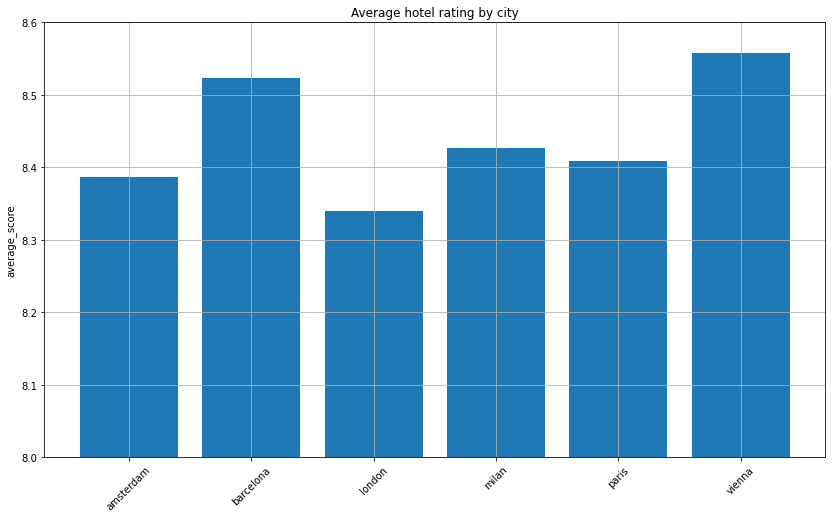

In [98]:
# Let's check how in which city ratings are higher
rating_country = train_data.groupby(by='hotel_city')[['average_score']].mean()

fig, ax = plt.subplots(figsize=[14, 8])

ax.bar(rating_country.index, rating_country['average_score'])

ax.set_ylabel('average_score')
ax.set_title('Average hotel rating by city')
plt.ylim(8, 8.6)
plt.xticks(rotation = 45)
plt.grid()

plt.show();


In [99]:
# Now we can encode features hotel_country and hotel_city
encoder = ce.OneHotEncoder(cols=['hotel_country']) 
type_bin = encoder.fit_transform(train_data['hotel_country'])
train_data = pd.concat([train_data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['hotel_city']) 
type_bin = encoder.fit_transform(train_data['hotel_city'])
train_data = pd.concat([train_data, type_bin], axis=1)


**Now before we continue with this feature we need to fill missing values which are in lat and lng columns**

### **1.2 Missing values**

lat    0.633655
lng    0.633655
dtype: float64


<AxesSubplot:>

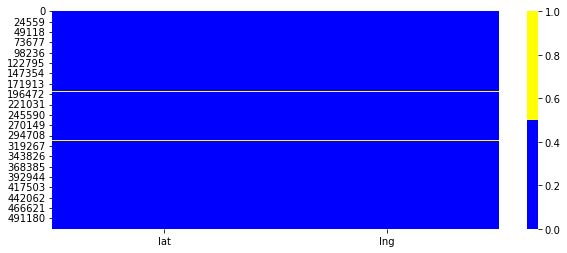

In [100]:
def missing_values_heatmap(data):
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
    print(cols_with_null)
    colors = ['blue', 'yellow'] 
    fig = plt.figure(figsize=(10, 4))
    cols = cols_with_null.index
    ax = sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colors))
    return ax

missing_values_heatmap(train_data)

In [101]:
missing_data = train_data[(train_data['lat'].isna() == True) | (train_data['lng'].isna() == True)]
print(missing_data.shape[0])
missing_data.head()

3268


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,8/26/2016,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United States of America,Not much,3,1558,Bugs in our room Bad Wifi,...,0,0,1,0,0,0,0,0,1,0
566,23 Rue Damr mont 18th arr 75018 Paris France,21,6/23/2016,8.3,Holiday Inn Paris Montmartre,United Kingdom,N a,3,298,Great location friendly and very helpful staff,...,0,0,0,0,0,1,0,0,0,0
724,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,333,8/6/2015,8.3,Fleming s Selection Hotel Wien City,United Arab Emirates,The bed so comfortable and room design,8,3672,Lovely location and friendly staff Close the ...,...,0,0,1,0,0,0,0,0,1,0
754,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,1/4/2016,7.8,Hotel Atlanta,Romania,No Negative,0,2724,location near the city centre quiet clean,...,0,0,1,0,0,0,0,0,1,0
1137,4 rue de la P pini re 8th arr 75008 Paris France,172,1/5/2016,8.8,Maison Albar Hotel Paris Op ra Diamond,Luxembourg,The breakfast was to minimalist for this price,9,1524,No Positive,...,0,0,0,0,0,1,0,0,0,0


**It is possible to get coordinates of each hotel but it requires using Google api which requires adding payment information. So I decided just to apply to hotels with missing values coordinates of the city where they are located.**

In [102]:
missing_data['lat'] = missing_data['cnt_lat']
missing_data['lng'] = missing_data['cnt_lng']
train_data[(train_data['lat'].isna() == True) | (train_data['lng'].isna() == True)] = missing_data


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**As there a no more NaN values we can now count distance between city center and the hotel**

In [103]:
%%time

# We'll use basic math for that
# create new distance feature
train_data['distance'] = float(0)
# approximate radius of earth in km
R = 6373.0
rows = train_data.index
for row in rows:
    lat1 = radians(train_data['lat'][row])
    lat2 = radians(train_data['cnt_lat'][row])
    lng1 = radians(train_data['lng'][row])
    lng2 = radians(train_data['cnt_lng'][row])
    dlng = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlng / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    train_data['distance'][row] = distance

train_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


CPU times: user 2min 41s, sys: 333 ms, total: 2min 41s
Wall time: 2min 41s


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_country_4,hotel_country_5,hotel_country_6,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6,distance
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,0,0,1,0,0,0,0,0,1.784296
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,0,1,0,0,0,0,0,1.286987
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,0,0,0,1,0,0,0,0,2.748187
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,0,0,0,1,0,0,0,0,4.266930
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,0,0,0,0,0,1,0,0,0,3.500280


In [104]:
# we can now see statistics within distance feature
train_data['distance'].describe()

count    515738.000000
mean          3.250628
std           2.582634
min           0.000000
25%           1.390642
50%           2.531100
75%           4.452420
max          17.744252
Name: distance, dtype: float64

**All hotels that have 0 distance to city center previously had NaN values for lat and lng. I prefer to assign them mean value of distance which is 3.25**

In [105]:
train_data[train_data['distance'] == 0] = train_data[train_data['distance'] == 0].assign(distance=3.25)

In [106]:
# Now it looks nice
train_data['distance'].describe()

count    515738.000000
mean          3.271222
std           2.569556
min           0.023708
25%           1.434970
50%           2.558848
75%           4.452420
max          17.744252
Name: distance, dtype: float64

It is possible to categorize distance to center

In [107]:
def distance_category(arg):
    if arg < 1:
        return 'less 1'
    elif arg < 3:
        return 'less 3'
    elif arg < 5:
        return 'less 5'
    elif arg >= 5:
        return 'more 5'

train_data['distance_cat'] = train_data['distance'].apply(distance_category)
train_data['distance_cat'].value_counts()

less 3    220493
less 5    118460
more 5     96620
less 1     80165
Name: distance_cat, dtype: int64

In [108]:
# Now we can encode feature distance_cat
encoder = ce.OneHotEncoder(cols=['distance_cat']) 
type_bin = encoder.fit_transform(train_data['distance_cat'])
train_data = pd.concat([train_data, type_bin], axis=1)

### **1.3 reviewer_nationality**

**In reviewer_nationality we have 225 different countries. We can categorize them by region.**

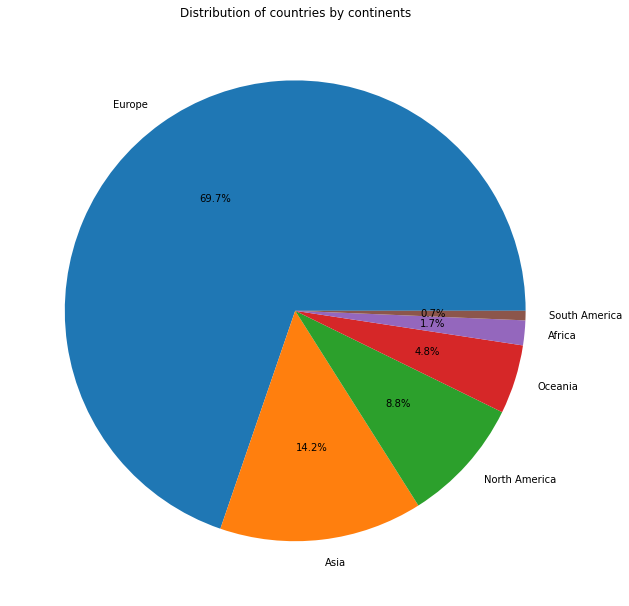

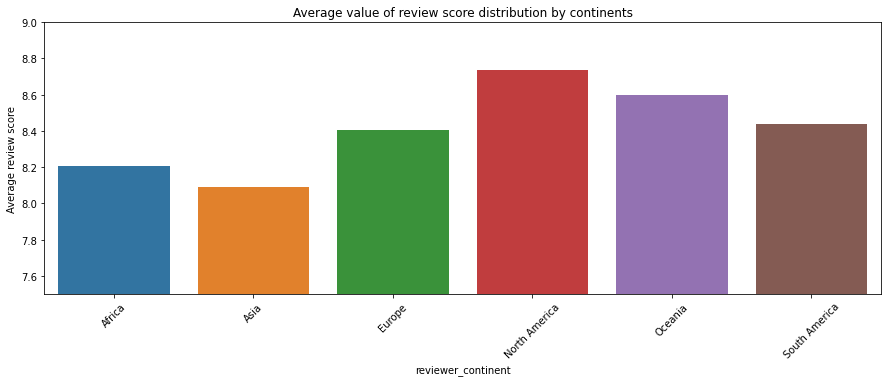

CPU times: user 4.35 s, sys: 534 ms, total: 4.89 s
Wall time: 4.4 s


In [109]:
%%time

# cutting spaces on both sides by using strip() in reviewer_nationality column
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: x.strip())
# filling gaps in rows by mode 
mode_nation = train_data['reviewer_nationality'].mode()[0]
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: mode_nation if x == "" else x)

# creating function that convert country to continent 
def country_to_continent(country_name):
    """This function by using "pycountry_convert" 
    package convert country to continent  
    Args:
        reviewer_nationality (str): the column of dataset
    Returns:
        continent (str)
    """ 
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return continent_name


# after running "country_to_continent" function were identified some countries 
# that don't fit to converting for various reasons like unrecognized states 
# so they were changed to near replaced recognized states
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: "Ukraine" if x == "Crimea" else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: "Serbia" if x == "Kosovo" else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                            lambda x: 'Georgia' if x == 'Abkhazia Georgia' 
                            else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Curaçao' if x == 'Cura ao' else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'USA' if x == 'U S Virgin Islands'
                                else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'USA'
                                if x == 'United States Minor Outlying Islands' 
                                else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Palestine'
                                if x == 'Palestinian Territory' else x)
# creating list with small islands countries that replaced around Puerto Rico   
puerto_ricos = ['St Maarten','Saint Barts',
                'Bonaire St Eustatius and Saba','Turks Caicos Islands',
                "Antigua Barbuda", "Saint Vincent Grenadines"]
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Puerto Rico' if x in puerto_ricos 
                                else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Italy' if x == 'Vatican City' else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Madagascar' if x == 'Reunion' else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Falkland Islands' 
                                if x == 'Falkland Islands Malvinas'else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Falkland Islands' if x == 'Antarctica' 
                                else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Canada'if x == 'St Pierre and Miquelon' 
                                else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Australia' if x=='Cocos K I' else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Indonesia' if x=='East Timor' else x)
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Svalbard' if x == 'Svalbard Jan Mayen'
                                else x)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
train_data['reviewer_nationality'] = train_data['reviewer_nationality'].apply(
                                lambda x: 'Central African Republic' 
                                if x == 'Central Africa Republic'else x) 

# just after these changes "country_to_continent" function
# was applied to 'reviewer_nationality' column
train_data['reviewer_continent'] = train_data['reviewer_nationality']\
                                        .apply(country_to_continent)

# creating pie cart to visualize how countries are distributed across continents
reviewer_continents = train_data['reviewer_continent'].value_counts()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    reviewer_continents,
    labels=reviewer_continents.index,
    autopct='%.1f%%'
)
axes.set_title('Distribution of countries by continents');

# plotting bar graph of the relationship reviwer score and reviewer_continent
pivot_continent = pd.pivot_table(
    data=train_data[train_data['is_train'] == 1],
    index='reviewer_continent', 
    values='reviewer_score', 
    aggfunc='mean'
)
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(x=pivot_continent.index, y=pivot_continent['reviewer_score']);
axes.set_title('Average value of review score distribution by continents');
axes.set_ylabel('Average review score');
axes.tick_params(axis='x', rotation=45)
plt.ylim(7.5, 9)
plt.show()



In [110]:
# Now we can encode  reviewer_continent feature
encoder = ce.OneHotEncoder(cols=['reviewer_continent']) 
type_bin = encoder.fit_transform(train_data['reviewer_continent'])
train_data = pd.concat([train_data, type_bin], axis=1)


In [111]:
# reviewer_continent may be added to the list of columns that would be further deleted
col_delete.append('reviewer_continent')

### **1.4 review_date**

In [112]:
# Firstly we convert review_date to datetime format
train_data['review_date'] = pd.to_datetime(train_data['review_date'])

# We may also create year, month and day features
train_data['month'] = pd.to_datetime(train_data['review_date']).dt.month
train_data['year'] = pd.to_datetime(train_data['review_date']).dt.year
train_data['day'] = pd.to_datetime(train_data['review_date']).dt.day

In [113]:
# also we may add weekday and weekend features
train_data['weekday'] = pd.to_datetime(train_data['review_date']).dt.weekday
train_data['weekend'] = train_data['weekday'].apply(lambda day: 1 if day==6 or day==5 else 0)

In [114]:
col_delete.append('review_date')

### **1.5 days_since_review**

In [115]:
# this feature consists of int value and str
# let's make it int

train_data['days_since_review'] = train_data['days_since_review'].str.split().str[0]
train_data['days_since_review'] = train_data['days_since_review'].astype('int')



### **1.6 positive_review and negative_review**

In [116]:
%%time

# Some reviews have confusing information
# We have to make them more clear

train_data['negative_review'] = train_data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
train_data['negative_review'] = train_data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
train_data['negative_review'] = train_data['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
train_data['negative_review'] = train_data['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
train_data['negative_review'] = train_data['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
train_data['positive_review'] = train_data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# we need to create 2 analyzers for positive and negative review assessment
neg_analyzer = SentimentIntensityAnalyzer()
pos_analyzer = SentimentIntensityAnalyzer()

train_data['neg_score'] = train_data['negative_review'].apply(lambda x: neg_analyzer.polarity_scores(x))
train_data['pos_score'] = train_data['positive_review'].apply(lambda x: pos_analyzer.polarity_scores(x))
train_data[['neg_score', 'pos_score']]


CPU times: user 4min 31s, sys: 779 ms, total: 4min 32s
Wall time: 4min 32s


,neg_score,pos_score
0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp..."
1,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
3,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.279, 'pos': 0.721, 'comp..."
4,"{'neg': 0.667, 'neu': 0.333, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'comp..."
...,...,...
515733,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp..."
515734,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp..."
515735,"{'neg': 0.071, 'neu': 0.836, 'pos': 0.093, 'co...","{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp..."
515736,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'comp..."


In [117]:
# now we can create new features:
train_data['n_review_sentiments_neg'] = train_data['neg_score'].apply(lambda x: x['neg'])
train_data['n_review_sentiments_neu'] = train_data['neg_score'].apply(lambda x: x['neu'])
train_data['n_review_sentiments_pos'] = train_data['neg_score'].apply(lambda x: x['pos'])
train_data['n_review_sentiments_compound'] = train_data['neg_score'].apply(lambda x: x['compound'])

train_data['p_review_sentiments_neg'] = train_data['pos_score'].apply(lambda x: x['neg'])
train_data['p_review_sentiments_neu'] = train_data['pos_score'].apply(lambda x: x['neu'])
train_data['p_review_sentiments_pos'] = train_data['pos_score'].apply(lambda x: x['pos'])
train_data['p_review_sentiments_compound'] = train_data['pos_score'].apply(lambda x: x['compound'])

### **1.7 tags**

**It could be useful to extract most popular tags. In order to do that we need to extract and clean them.** 

In [118]:
# extracting and cleaning
def tag_clean(arg):
    arg = arg[2:-2].split('\', \'')
    return arg

train_data['new_tags'] = train_data['tags'].apply(tag_clean)

# selecting top 30 tags
df = train_data.explode('new_tags')
tags_counts = df['new_tags'].value_counts()[:30]
df_tags_counts = pd.DataFrame(tags_counts).reset_index()
df_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(df_tags_counts['unique_tags'])

**Now we can create new features named as key tags. If tag is in tags feature value is 1 if not - 0.**

In [119]:
for tag in top_tags:
    tag_name = str(tag)
    train_data[tag_name] =  train_data['tags'].apply(lambda x: 1 if tag_name in x else 0)

## **2. Correlation analysis**

**Now we have to check which features have highest level of correlation and delete them to avoid mulicollinearity**

In [120]:
corr = train_data.corr()
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending = False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
print('Features with highest correlation')
corr_unstack.head(30)

Features with highest correlation


,level_0,level_1,0
1594,hotel_city_2,hotel_country_2,1.000000
1674,hotel_city_3,hotel_country_3,1.000000
1754,hotel_city_4,hotel_country_4,1.000000
1834,hotel_city_5,hotel_country_5,1.000000
1914,hotel_city_6,hotel_country_6,1.000000
1514,hotel_city_1,hotel_country_1,1.000000
877,cnt_lat,lat,0.999987
957,cnt_lng,lng,0.999942
3439,n_review_sentiments_pos,n_review_sentiments_neu,0.938776
796,is_train,reviewer_score,0.931753


In [121]:
# manually add columns in the drop list

col_delete.extend(['reviewer_nationality', 'negative_review', 'day',
                  'positive_review', 'tags', 'lat', 'lng', 'hotel_country', 
                   'hotel_city', 'cnt_lat', 'cnt_lng', 'distance_cat', 'neg_score', 
                   'pos_score', 'new_tags', 'distance', ' Twin Room '])


In [122]:
# deleting
train_data = train_data.drop(columns=col_delete, axis=1)

**Now we can visulize correlation of our features**

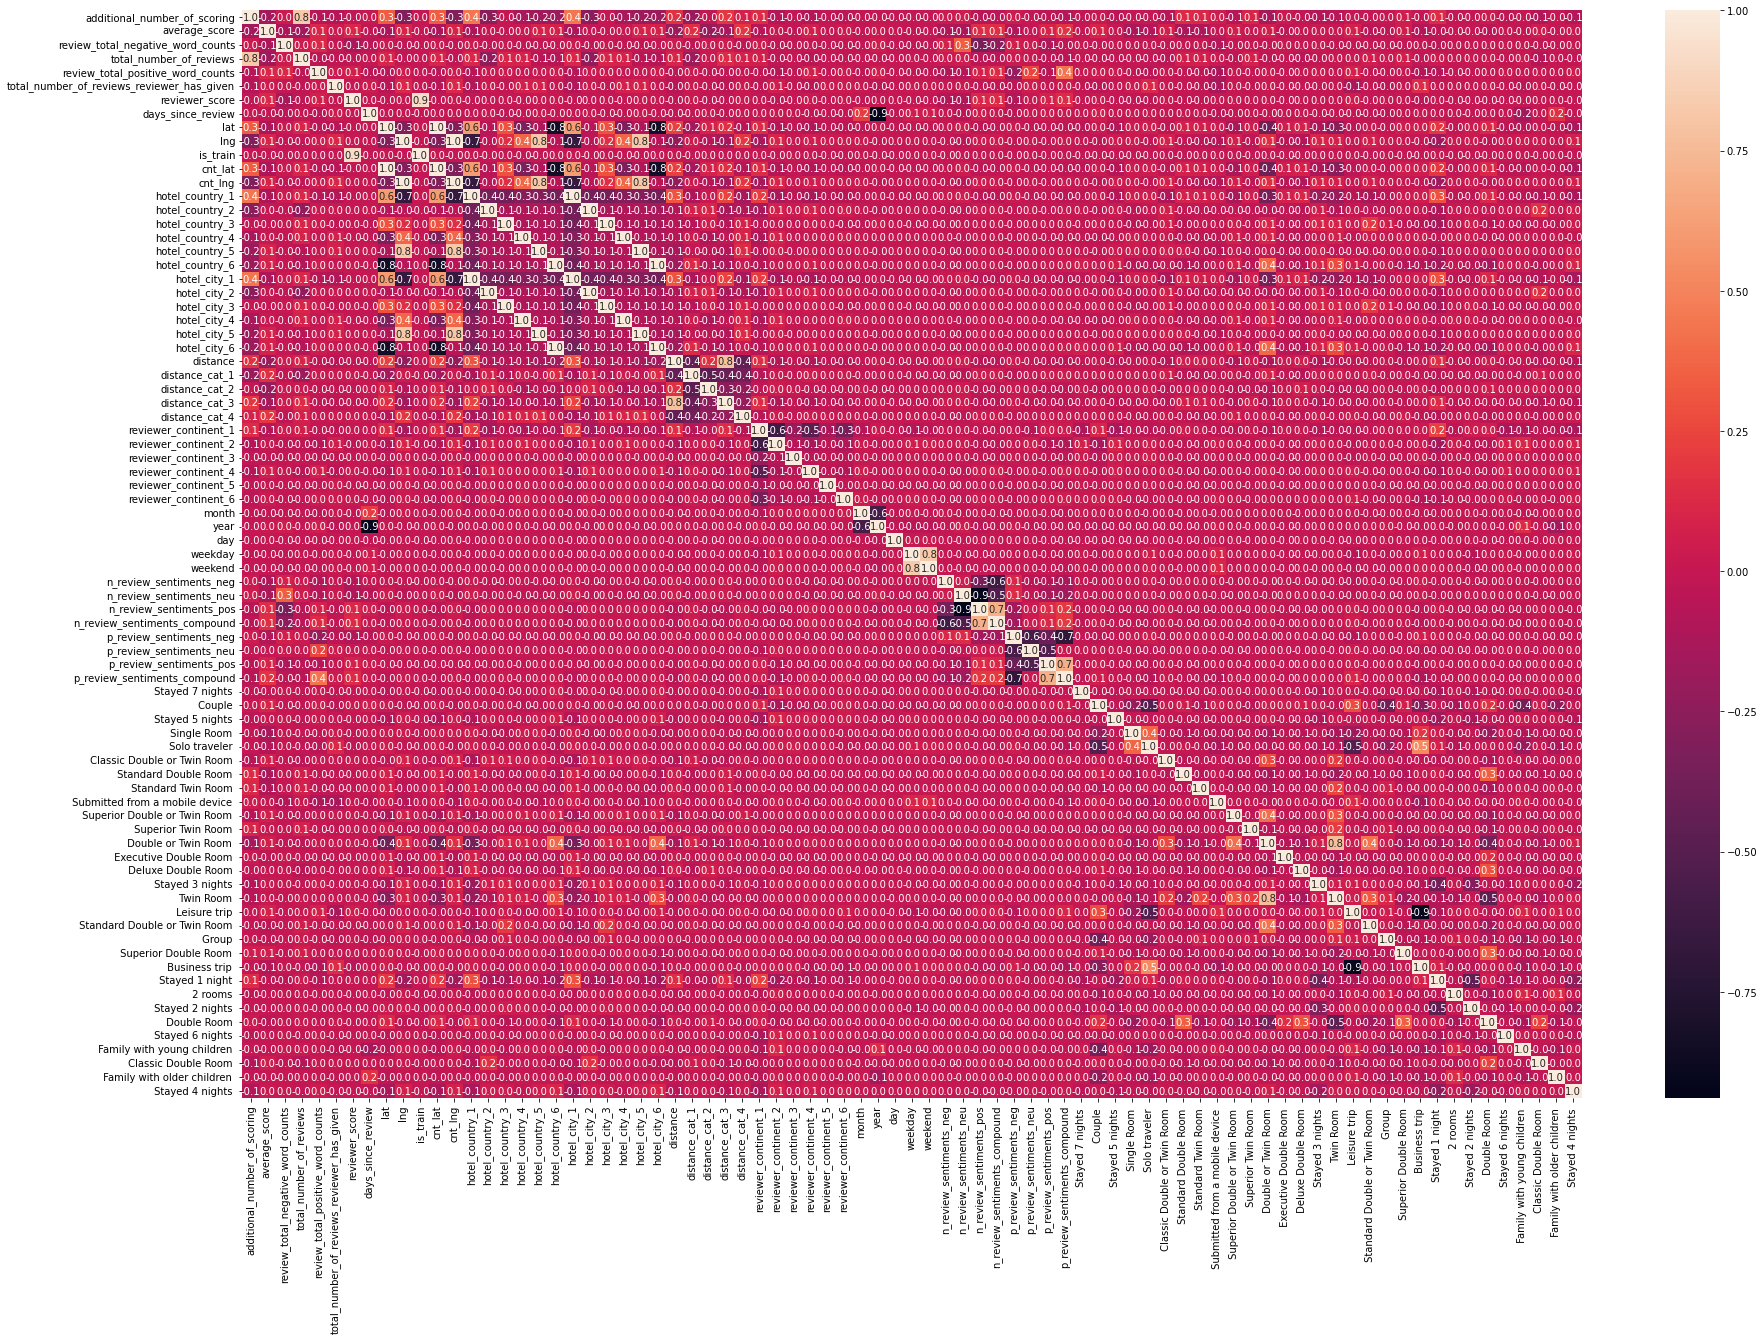

In [123]:
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(corr, annot = True,  fmt='.1f');


## **3. Machine learning**

In [124]:
test_data = train_data[train_data['is_train'] == 0]
train_data = train_data[train_data['is_train'] == 1]
train_data = train_data.drop(['is_train'], axis=1)
test_data = test_data.drop(['is_train'], axis=1)

y = train_data.reviewer_score.values            # our target
X = train_data.drop(['reviewer_score'], axis=1)

In [125]:
%%capture
!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Constants definition for lightautoml
N_THREADS = 10
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.3
TIMEOUT = 5000 # equal to 15 minutes
TARGET_NAME = 'reviewer_score'

# Fixing random state
np.random.seed(RANDOM_STATE)


In [126]:
%%time

# separation into training and testing data
# tr_data - train data
# te_data - validation data

tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

CPU times: user 399 ms, sys: 90 ms, total: 489 ms
Wall time: 488 ms


In [127]:
%%time

# we select regression and mae for metric

task = Task('reg', loss = 'mae', metric = 'mae')

# select target column and columns for drop
roles = {
    'target': TARGET_NAME,
    'drop': []
}

# Сreate object TabularAutoML

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)



# Start of model learning (selecting data, target, display level)
# After completeon we get out of fold prediction

oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

# infro about automl processing
# print(automl.create_model_str_desc())

[14:27:54] Stdout logging level is INFO.
[14:27:54] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[14:27:54] Task: reg

[14:27:54] Start automl preset with listed constraints:
[14:27:54] - time: 5000.00 seconds
[14:27:54] - CPU: 10 cores
[14:27:54] - memory: 16 GB

[14:27:54] Train data shape: (270762, 72)

[14:28:06] Layer 1 train process start. Time left 4987.86 secs
[14:28:27] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:28:58] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.9132644554568763
[14:28:58] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:28:58] Time left 4936.38 secs

[14:29:30] Selector_LightGBM fitting and predicting completed
[14:29:49] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[14:35:44] Time limit exceeded after calculating fold 8

[14:35:44] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.8316710586746191
[14:35:44] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting com

CPU times: user 390 ms, sys: 210 ms, total: 599 ms
Wall time: 261 ms


<AxesSubplot:xlabel='Feature'>

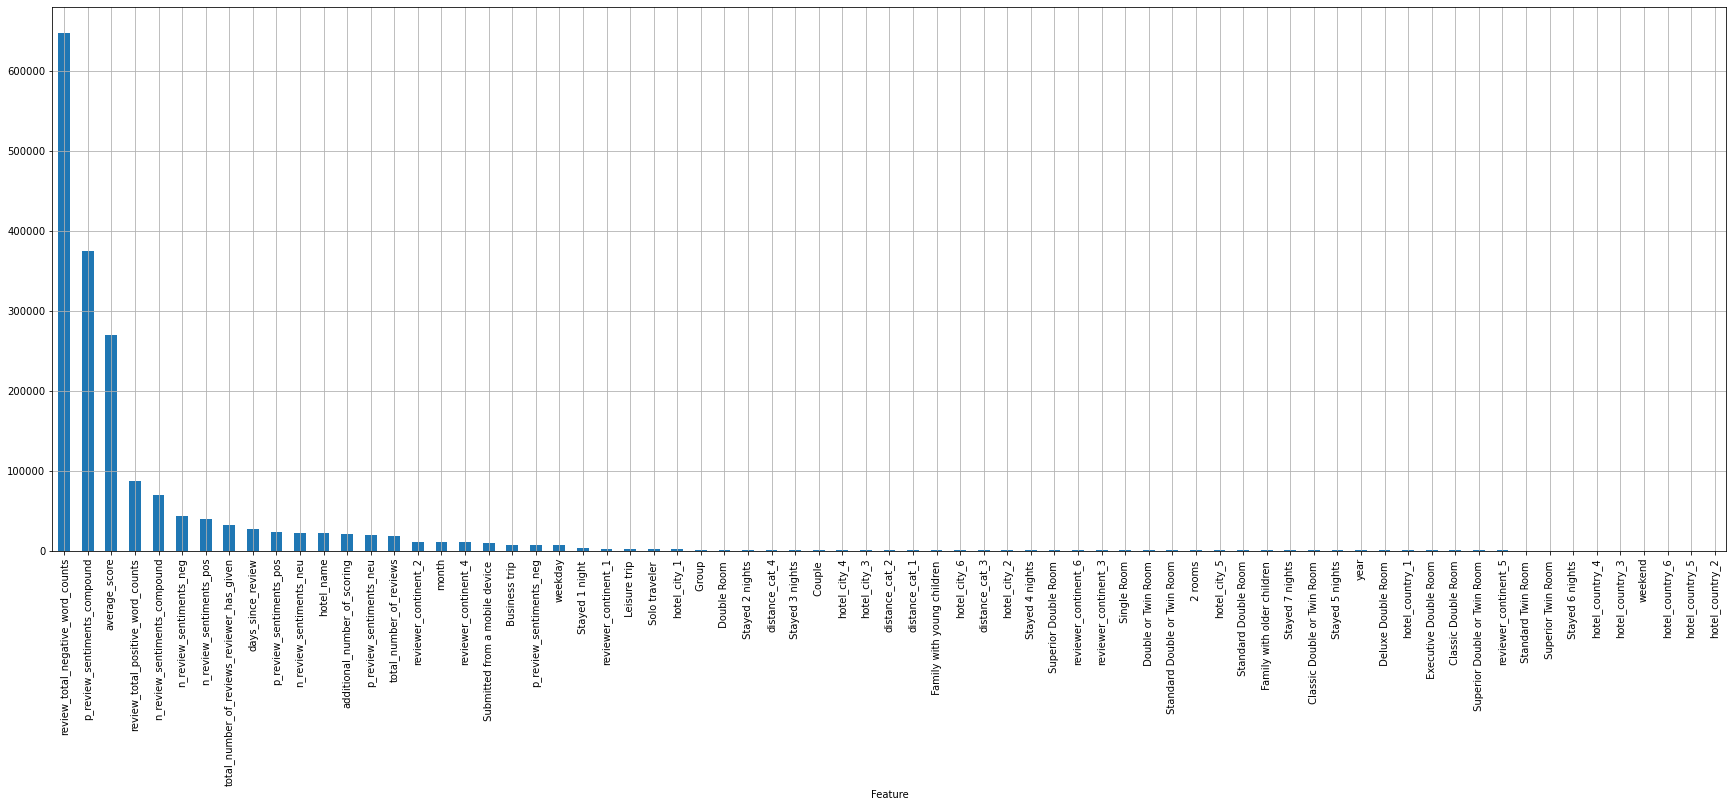

In [128]:
%%time
#  Assessing significance of our features on graph
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)


In [129]:
# Getting prediction on validation data using automl.predict
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[5.245358 ],
       [7.9739723],
       [9.296229 ],
       ...,
       [9.475218 ],
       [7.553813 ],
       [9.870048 ]], dtype=float32)
Shape = (116041, 1)


In [130]:
from sklearn import metrics # assessment of model precision  
#print(f'TRAIN  score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print('MAPE:', metrics.mean_absolute_percentage_error(te_data[TARGET_NAME].values, te_pred.data[:, 0]))

MAPE: 0.12172544041386543


In [131]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')


Prediction for te_data:
array([[8.714645 ],
       [8.199955 ],
       [8.584057 ],
       ...,
       [7.9602337],
       [9.76798  ],
       [7.5953875]], dtype=float32)
Shape = (128935, 1)


In [132]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('submission.csv', index = False)